## Assignment 3-4

### Group 2


#### **Part 1: Double Lasso and DAGs (20 points)**


1. Consider the US census data from the year 2015 to analyse the effect of college graduate (clg) status
and it’s interaction effects with gender (sex), location (mw, so,we, ne) and both on wage jointly. All
other variables denote some other socio-economic characteristics, e.g. marital status, occupation, and
experience.

In [45]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import patsy
import statsmodels.api as sms
import warnings
warnings.simplefilter('ignore')

In [21]:
url = "https://github.com/d2cml-ai/CausalAI-Course/raw/refs/heads/main/data/wage2015_subsample_inference.csv"
df = pd.read_csv(url)


* Generate the dataset with all the two-way interactions between variables. Make sure that the categorical variables are transformed to dummies properly. Also, note that the resulting dataset contains the treatment and it’s interactions with the other variables of interest, so you don’t need to generate them separately. (2 pts)

In [22]:
y = np.log(df["wage"]).values
Z = df.drop(['wage', 'lwage'], axis=1)

In [35]:
Zcontrols = patsy.dmatrix(
    '0 + (shs + hsg + scl + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2',
    data=Z,  
    return_type='dataframe'
)

# Centrar Zcontrols en torno a su media
Zcontrols = Zcontrols - Zcontrols.mean(axis=0)

In [36]:
Zhet = patsy.dmatrix(
    '0 + (sex + mw + so + we + ne + shs + hsg + scl + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2',
    data=Z,
    return_type='dataframe'
)

Zhet = Zhet - Zhet.mean(axis=0)

In [37]:
Zhet["clg"] =Z["clg"]
Zinteractions = patsy.dmatrix(
    '0 + clg + clg * (sex + mw + so + we + ne)', 
    Zhet, 
    return_type='dataframe'
)
interaction_cols = [c for c in Zinteractions.columns if c.startswith('clg')]


In [38]:
X = pd.concat([Zinteractions, Zcontrols], axis=1)
X.shape

(5150, 788)

* Use the double lasso technique to find the effect of the treatment and it’s relevant interactions on
the wage. To tune the penalization parameter in the lasso step, cross-validate it. (4 pts)

In [ ]:
#!pip install multiprocess
#!git clone https://github.com/maxhuppertz/hdmpy.git


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Cloning into 'hdmpy'...


In [40]:
import sys
sys.path.insert(1, "./hdmpy")

In [42]:
import hdmpy
from sklearn.base import BaseEstimator


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])


def lasso_model():
    return RLasso(post=False)

In [43]:
alpha = {}
res_y, res_D, epsilon = {}, {}, {}
for c in interaction_cols:
    print(f"Double Lasso for target variable {c}")
    D = X[c].values
    W = X.drop([c], axis=1)
    res_y[c] = y - lasso_model().fit(W, y).predict(W)
    res_D[c] = D - lasso_model().fit(W, D).predict(W)
    final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
    epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
    alpha[c] = [final.coef_[0]]

# Calculate the covariance matrix of the estimated parameters
V = np.zeros((len(interaction_cols), len(interaction_cols)))
for it, c in enumerate(interaction_cols):
    Jc = np.mean(res_D[c]**2)
    for itp, cp in enumerate(interaction_cols):
        Jcp = np.mean(res_D[cp]**2)
        Sigma = np.mean(res_D[c] * epsilon[c] * epsilon[cp] * res_D[cp])
        V[it, itp] = Sigma / (Jc * Jcp)

# Calculate standard errors for each parameter
n = X.shape[0]
for it, c in enumerate(interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]

# put all in a dataframe
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])


Double Lasso for target variable clg
Double Lasso for target variable clg:sex
Double Lasso for target variable clg:mw
Double Lasso for target variable clg:so
Double Lasso for target variable clg:we
Double Lasso for target variable clg:ne


* Report a summary of the estimation of the parameters of interest. (2 pts)



In [44]:
summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['Std. Error'] = df['stderr']
summary['p-value'] = norm.sf(np.abs(df['point'] / df['stderr']), loc=0, scale=1) * 2
summary['ci_lower'] = df['point'] - 1.96 * df['stderr']
summary['ci_upper'] = df['point'] + 1.96 * df['stderr']
summary

,Estimate,Std. Error,p-value,ci_lower,ci_upper
clg,-0.169449,0.024099,2.044185e-12,-0.216683,-0.122216
clg:sex,0.007862,0.029939,7.928646e-01,-0.050819,0.066542
clg:mw,-1827.261546,952.564661,5.507874e-02,-3694.288282,39.765189
clg:so,-2077.103043,1912.933695,2.775583e-01,-5826.453085,1672.246999
clg:we,297.995529,514.352979,5.623463e-01,-710.136310,1306.127368
clg:ne,874.556194,433.909899,4.384968e-02,24.092792,1725.019595


* Interpret your results. In which group does the college graduate status has more impact over the
wage? (2 pts)

* **clg**: The clg variable shows a negative coefficient of -0169, with a highly significant p-value of 2.04e-12. This suggests that, without interactions, being a college graduate has a negative effect on wage in this model. However, this main affect may change if we consider the interaction between other variables.

* **clg:sex**: the interaction between clg and sex has a small positive coefficiente of 0.0079 and a high p-value of 0-79. This indicates that the impact of being a college graduate on wage does not vary significantly between genders in this model.

* **clg:mw**: The interaction between clg and mw (midwest) shows a negative coefficient of -1827.26, but a high p-value of 0.55. This suggests that in the Midwest, being a college graudate doesn't significantly impact wage compared to other regiones

* **clg:we**: This interaction shows a positive coefficient of 297.99 with a high p-value (0.56). This indicates that in the West, being a college graudate doesn't significantly impact wage compared to other regiones

* **clg:ne**: This interaction shows a positive coefficient and a relatively low p-value of 0.0438, *suggesting statistical significance*. This implies that in the Northweast, being a college graduate has a positive and significant impact on wages compared to the rest of the regiones.

To sum up, the **Northeast is the region where college graduate status has te most positive impact on wages**, reflected in the coefficient and p-value of  the relation between clg and ne. Therefore, college graduates in the Northeast appear to benefit more in terms of wages. 



2. For the following examples, draw a coherent Directed Acyclic Graph and indicate the confounders, colliders and the proper controls (if they exist).

* You are trying to study the effect of youth smoking on lung function. Your dataset contains the
following variables : (5 pts)

        i. Individual smoking behavior (Treatment)
    
        ii. Forced respiratory volume (Outcome)
    
        iii. Age
    
        iv. Height
    
        v. Sex

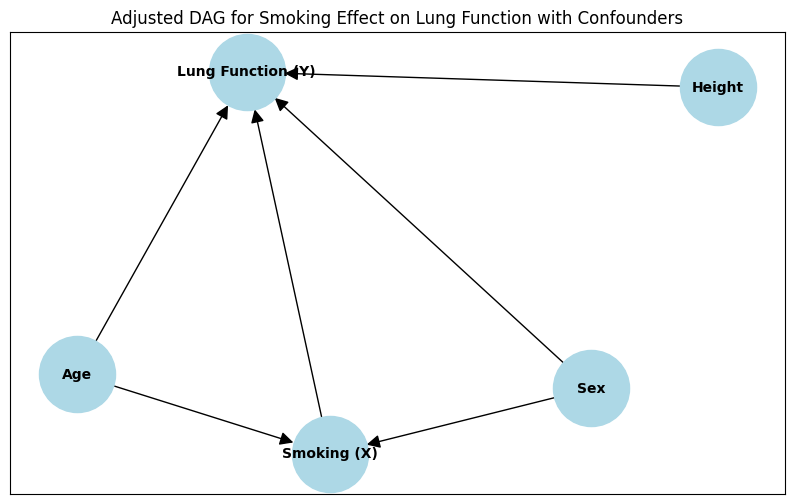

In [60]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(["Smoking (X)", "Lung Function (Y)", "Age", "Height", "Sex"])

# Add edges (causal relationships)
G.add_edges_from([
    ("Age", "Smoking (X)"),        # Age affects smoking
    ("Age", "Lung Function (Y)"),  # Age affects lung function
    ("Height", "Lung Function (Y)"), # Height affects lung function
    ("Sex", "Smoking (X)"),        # Sex affects smoking
    ("Sex", "Lung Function (Y)"),  # Sex affects lung function
    ("Smoking (X)", "Lung Function (Y)") # Smoking affects lung function
])

# Draw the DAG
plt.figure(figsize=(10, 6))
nx.draw_networkx(G, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("Adjusted DAG for Smoking Effect on Lung Function with Confounders")
plt.show()


* You are trying to study the effect of breast feeding in the number of infections a baby is likely to
have. Your dataset contains the following variables : (5 pts)

        i. Breast fed (Treatment)
        ii. Number of infections of the baby (Outcome)
        iii. Marital status
        iv. Family income
        v. Education
        vi. Number of children in the house
        vii. Childcare outside the home

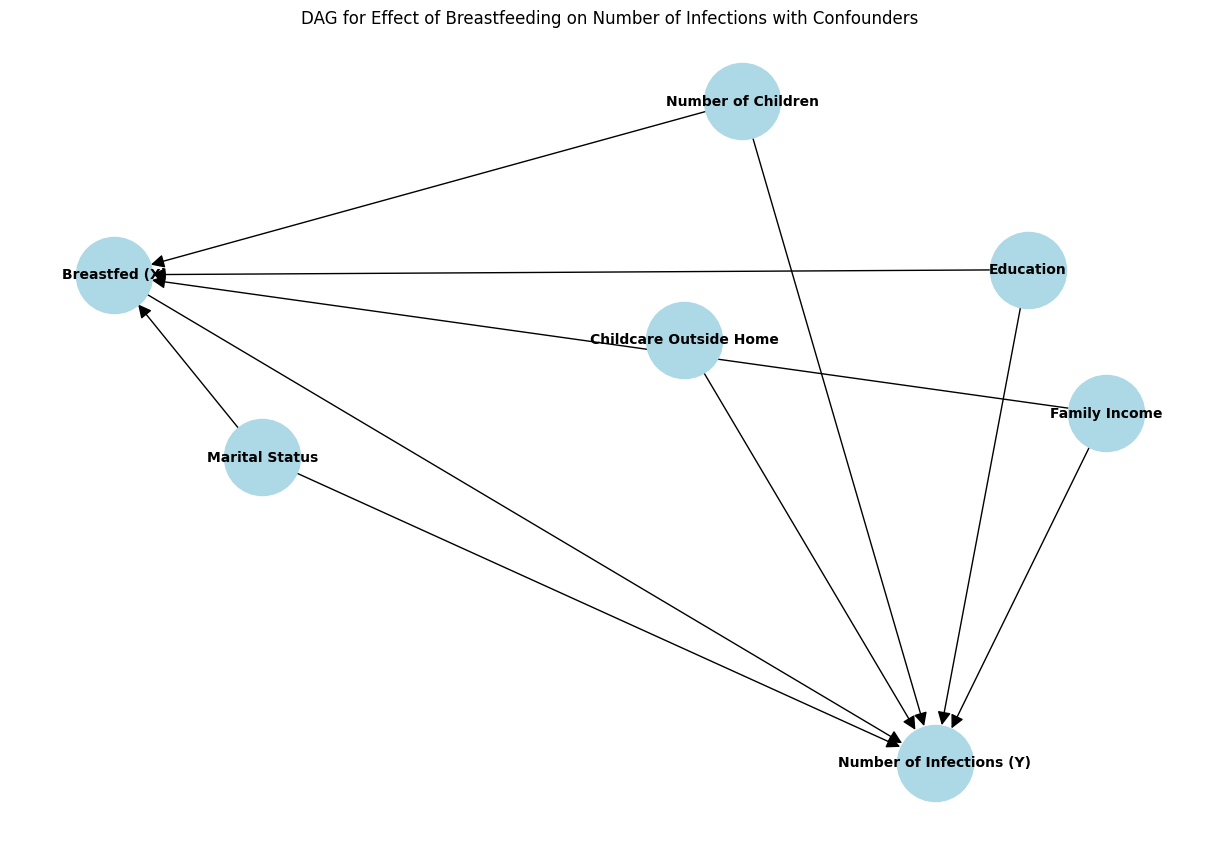

In [61]:


# Initialize the graph
G = nx.DiGraph()

# Add nodes for each variable
G.add_nodes_from([
    "Breastfed (X)", "Number of Infections (Y)", "Marital Status", 
    "Family Income", "Education", "Number of Children", "Childcare Outside Home"
])

# Add edges based on causal assumptions
# Direct effect of Breastfeeding on Infections
G.add_edge("Breastfed (X)", "Number of Infections (Y)")

# Confounders affecting both Breastfeeding and Infections
G.add_edge("Marital Status", "Breastfed (X)")
G.add_edge("Marital Status", "Number of Infections (Y)")

G.add_edge("Family Income", "Breastfed (X)")
G.add_edge("Family Income", "Number of Infections (Y)")

G.add_edge("Education", "Breastfed (X)")
G.add_edge("Education", "Number of Infections (Y)")

G.add_edge("Number of Children", "Breastfed (X)")
G.add_edge("Number of Children", "Number of Infections (Y)")

# Childcare affecting only Infections
G.add_edge("Childcare Outside Home", "Number of Infections (Y)")

# Draw the DAG
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Layout for a nice spread of nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("DAG for Effect of Breastfeeding on Number of Infections with Confounders")
plt.show()
